# Multivariate Time Series Datasets - EDA

This notebook explores three datasets from the [MvTS repository](https://github.com/MTS-BenchMark/MvTS) for testing joint imputation methods.

## Datasets Overview

| Dataset | Nodes | Timesteps | Granularity | Start Date | Description |
|---------|-------|-----------|-------------|------------|-------------|
| **electricity** | 321 | 26,304 | 1 hour | 2016-07-01 | Hourly electricity consumption from 321 clients |
| **exchange_rate** | 8 | 7,588 | 1 day | 1990-01-01 | Daily exchange rates of 8 currencies |
| **ETTh1** | 7 | 17,420 | 1 hour | 2016-07-01 | Electricity Transformer Temperature - 7 sensors |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 4)

In [2]:
def load_h5_dataset(filepath):
    """Load dataset from MvTS h5 format."""
    with h5py.File(filepath, 'r') as f:
        raw_data = np.array(f['raw_data']).squeeze()  # Remove trailing dim (T, N, 1) -> (T, N)
        
        # Adjacency matrix (may be zeros if not available)
        adj = np.array(f['adjacency_matrix']) if 'adjacency_matrix' in f else None
        
        # Time information
        if 'time' in f:
            time_raw = np.array(f['time'])
            time = pd.to_datetime([t.decode() for t in time_raw])
        else:
            time = None
    
    return raw_data, adj, time


def dataset_summary(name, data, time):
    """Print summary statistics for a dataset."""
    print(f"{'='*60}")
    print(f"Dataset: {name}")
    print(f"{'='*60}")
    print(f"Shape: {data.shape} (timesteps x nodes)")
    print(f"Timesteps: {data.shape[0]:,}")
    print(f"Nodes/Variables: {data.shape[1]}")
    if time is not None:
        print(f"Time range: {time[0]} to {time[-1]}")
        print(f"Duration: {time[-1] - time[0]}")
    print(f"\nValue statistics:")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  Mean: {data.mean():.4f}")
    print(f"  Std: {data.std():.4f}")
    print(f"  NaN count: {np.isnan(data).sum()}")
    print()

---
## 1. Electricity Dataset

**Description:** Hourly electricity consumption (in kWh) from 321 clients collected over ~3 years.

**Why good for joint imputation:** All households share similar daily patterns (morning/evening peaks) and weekly cycles (weekday vs weekend). This shared periodicity is exactly what the joint ℓ2,1 sparse recovery exploits.

In [ ]:
elec_data, elec_adj, elec_time = load_h5_dataset('../data/electricity.h5')
dataset_summary('electricity', elec_data, elec_time)

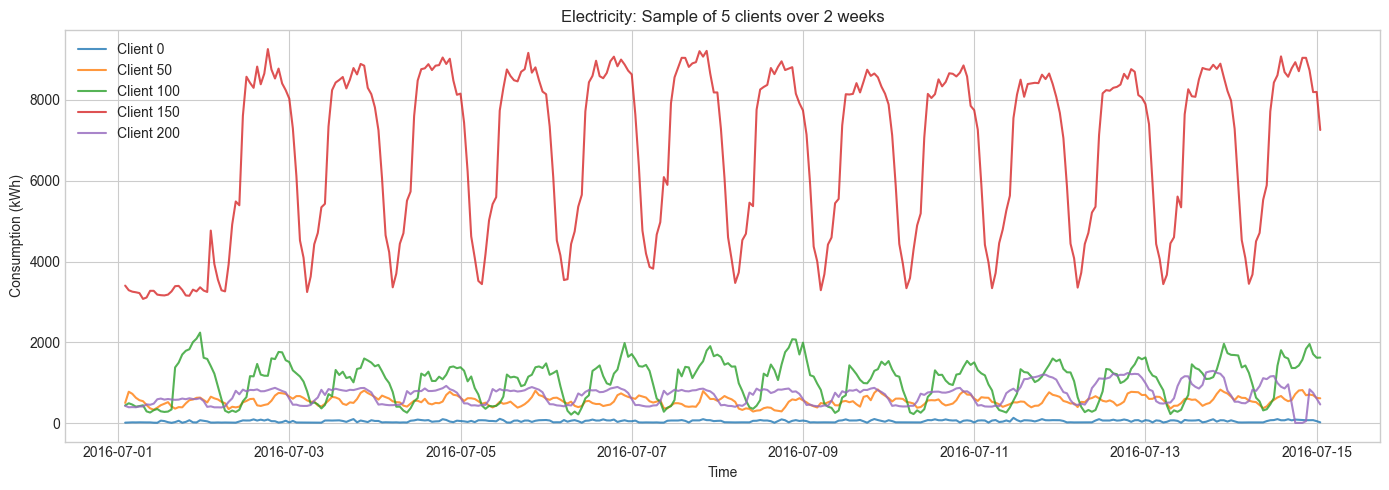

In [4]:
# Plot sample of 5 clients over 2 weeks
n_hours = 24 * 14  # 2 weeks
sample_clients = [0, 50, 100, 150, 200]

fig, ax = plt.subplots(figsize=(14, 5))
for i, client in enumerate(sample_clients):
    ax.plot(elec_time[:n_hours], elec_data[:n_hours, client], 
            label=f'Client {client}', alpha=0.8)

ax.set_xlabel('Time')
ax.set_ylabel('Consumption (kWh)')
ax.set_title('Electricity: Sample of 5 clients over 2 weeks')
ax.legend()
plt.tight_layout()
plt.show()

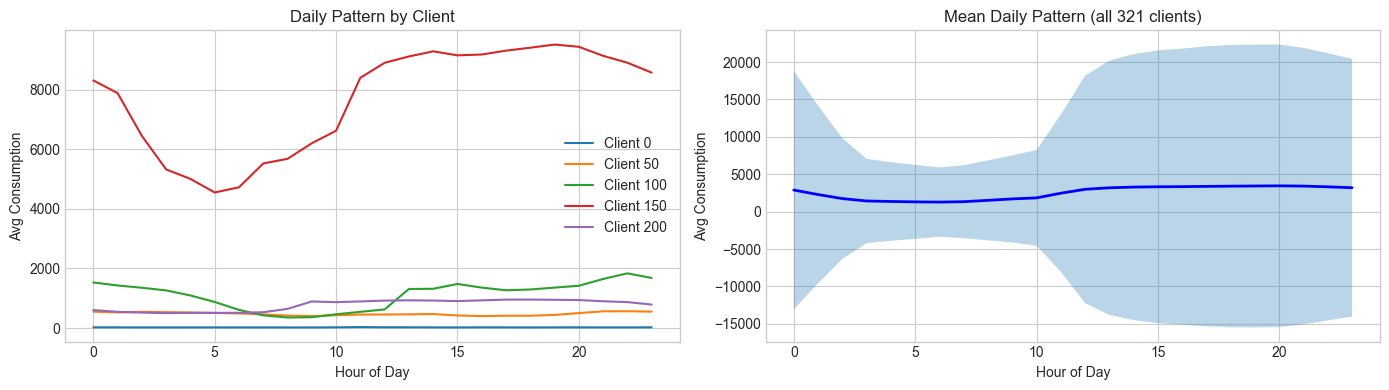

In [5]:
# Average daily pattern across all clients
elec_df = pd.DataFrame(elec_data, index=elec_time)
elec_df['hour'] = elec_df.index.hour

hourly_avg = elec_df.groupby('hour').mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: average pattern for selected clients
for client in sample_clients:
    axes[0].plot(hourly_avg.index, hourly_avg[client], label=f'Client {client}')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Avg Consumption')
axes[0].set_title('Daily Pattern by Client')
axes[0].legend()

# Right: mean across all clients with std band
mean_pattern = hourly_avg.iloc[:, :-1].mean(axis=1)  # exclude 'hour' column
std_pattern = hourly_avg.iloc[:, :-1].std(axis=1)
axes[1].fill_between(hourly_avg.index, mean_pattern - std_pattern, 
                     mean_pattern + std_pattern, alpha=0.3)
axes[1].plot(hourly_avg.index, mean_pattern, 'b-', linewidth=2)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Avg Consumption')
axes[1].set_title('Mean Daily Pattern (all 321 clients)')

plt.tight_layout()
plt.show()

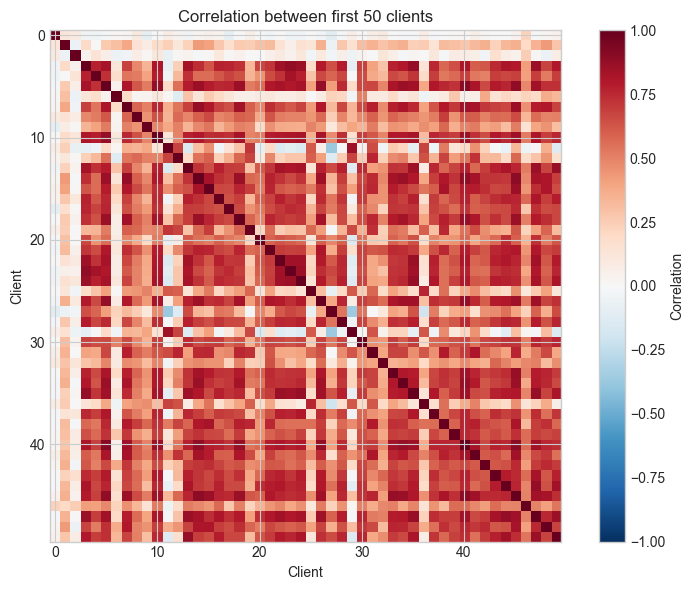

Average pairwise correlation: 0.491


In [6]:
# Correlation heatmap (subset of clients)
subset = elec_data[:, :50]  # first 50 clients
corr = np.corrcoef(subset.T)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_title('Correlation between first 50 clients')
ax.set_xlabel('Client')
ax.set_ylabel('Client')
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

print(f"Average pairwise correlation: {corr[np.triu_indices(50, k=1)].mean():.3f}")

---
## 2. Exchange Rate Dataset

**Description:** Daily exchange rates of 8 countries' currencies (relative to USD) from 1990-2010.

**Why good for joint imputation:** Currencies are economically linked - they respond to similar global events, interest rate changes, and market sentiment. The shared macro-economic drivers create correlated frequency content.

In [ ]:
exch_data, exch_adj, exch_time = load_h5_dataset('../data/exchange_rate.h5')
dataset_summary('exchange_rate', exch_data, exch_time)

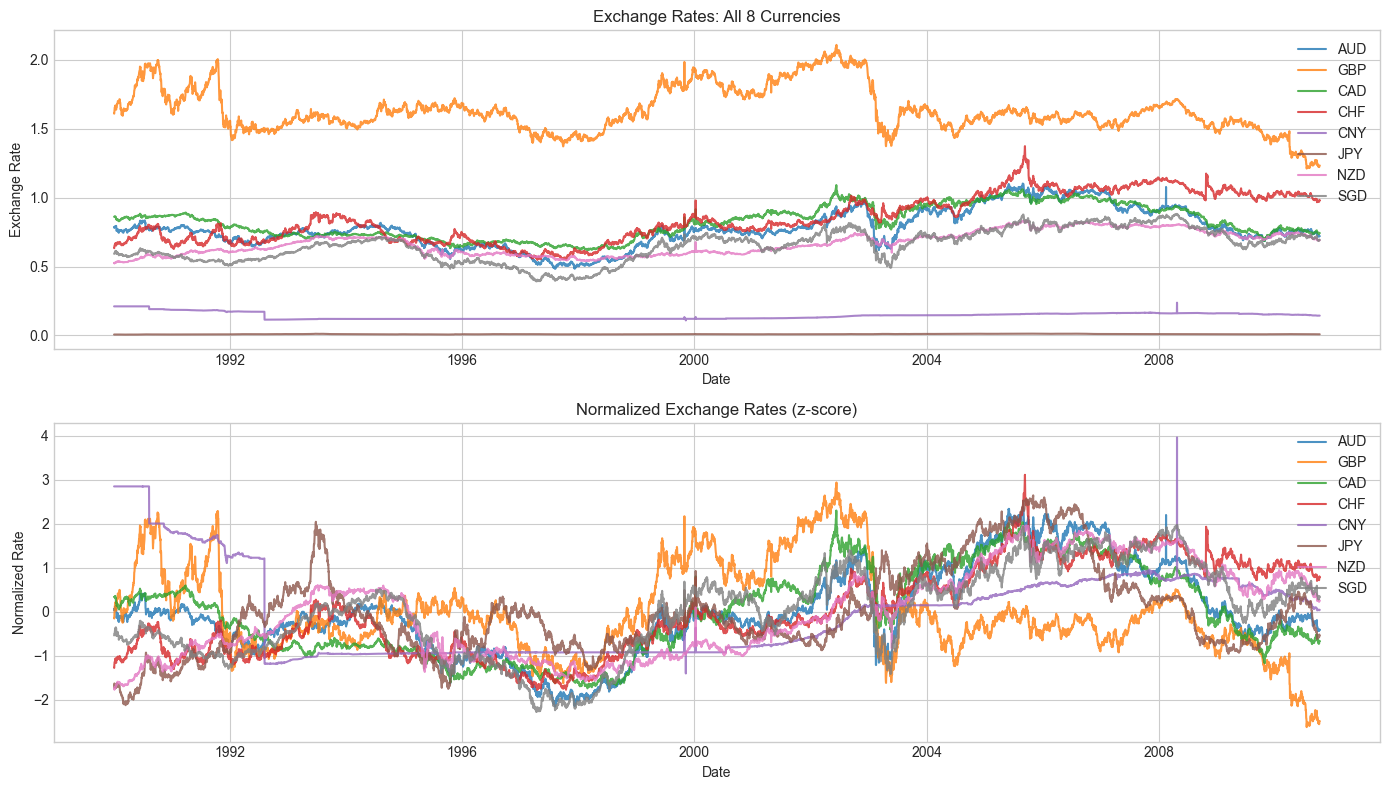

In [8]:
# Currency names (typical for this dataset)
currency_names = ['AUD', 'GBP', 'CAD', 'CHF', 'CNY', 'JPY', 'NZD', 'SGD']

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Raw values
for i in range(exch_data.shape[1]):
    name = currency_names[i] if i < len(currency_names) else f'Currency {i}'
    axes[0].plot(exch_time, exch_data[:, i], label=name, alpha=0.8)

axes[0].set_xlabel('Date')
axes[0].set_ylabel('Exchange Rate')
axes[0].set_title('Exchange Rates: All 8 Currencies')
axes[0].legend(loc='upper right')

# Normalized (to compare patterns)
exch_norm = (exch_data - exch_data.mean(axis=0)) / exch_data.std(axis=0)
for i in range(exch_data.shape[1]):
    name = currency_names[i] if i < len(currency_names) else f'Currency {i}'
    axes[1].plot(exch_time, exch_norm[:, i], label=name, alpha=0.8)

axes[1].set_xlabel('Date')
axes[1].set_ylabel('Normalized Rate')
axes[1].set_title('Normalized Exchange Rates (z-score)')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

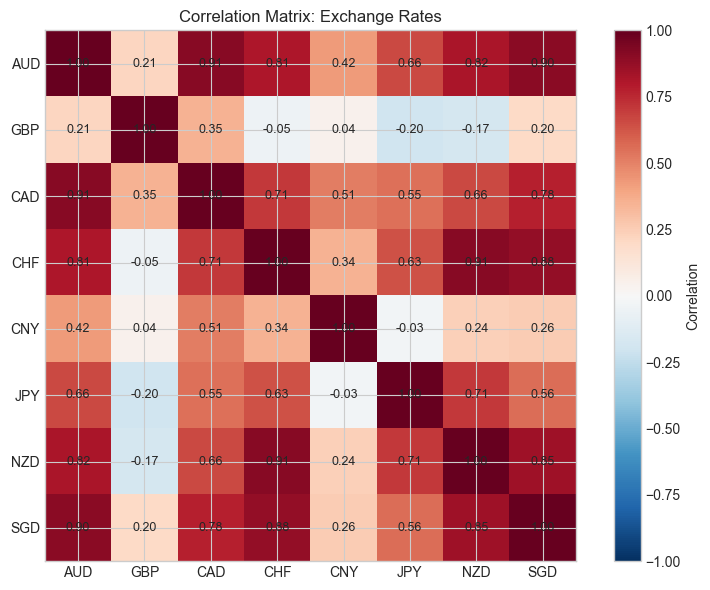

Average pairwise correlation: 0.480


In [9]:
# Correlation matrix
corr_exch = np.corrcoef(exch_data.T)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_exch, cmap='RdBu_r', vmin=-1, vmax=1)

# Labels
ax.set_xticks(range(len(currency_names)))
ax.set_yticks(range(len(currency_names)))
ax.set_xticklabels(currency_names)
ax.set_yticklabels(currency_names)

# Add correlation values
for i in range(len(currency_names)):
    for j in range(len(currency_names)):
        ax.text(j, i, f'{corr_exch[i, j]:.2f}', ha='center', va='center', fontsize=9)

ax.set_title('Correlation Matrix: Exchange Rates')
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

print(f"Average pairwise correlation: {corr_exch[np.triu_indices(8, k=1)].mean():.3f}")

---
## 3. ETTh1 Dataset (Electricity Transformer Temperature)

**Description:** Hourly measurements from 7 sensors on an electricity transformer, including:
- HUFL: High UseFul Load
- HULL: High UseLess Load  
- MUFL: Middle UseFul Load
- MULL: Middle UseLess Load
- LUFL: Low UseFul Load
- LULL: Low UseLess Load
- OT: Oil Temperature (target variable)

**Why good for joint imputation:** All sensors measure the same physical system (one transformer). They share thermal dynamics - when load increases, all temperatures rise together with similar lag patterns.

In [ ]:
ett_data, ett_adj, ett_time = load_h5_dataset('../data/ETTh1.h5')
dataset_summary('ETTh1', ett_data, ett_time)

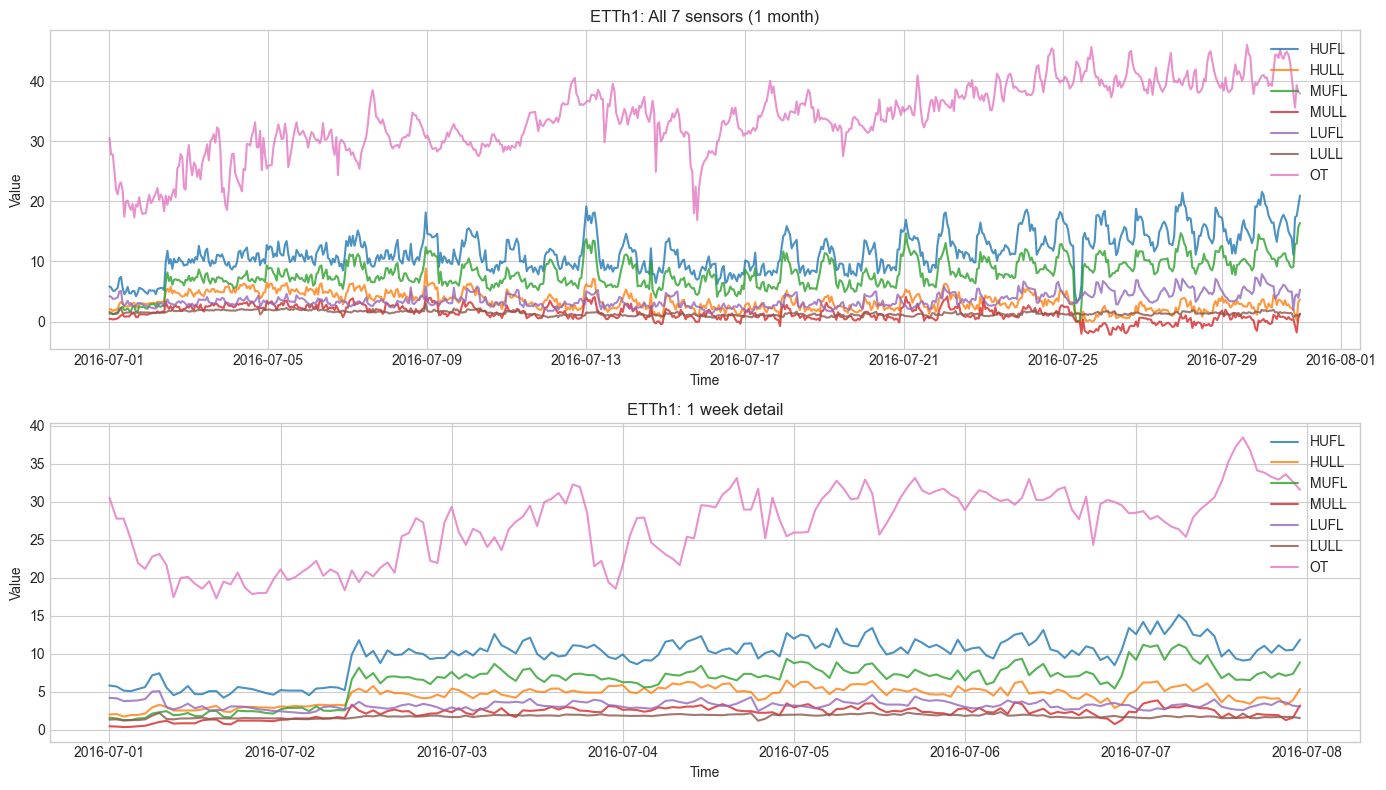

In [11]:
sensor_names = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

# Plot 1 month of data
n_hours = 24 * 30  # 1 month

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Raw values
for i in range(ett_data.shape[1]):
    name = sensor_names[i] if i < len(sensor_names) else f'Sensor {i}'
    axes[0].plot(ett_time[:n_hours], ett_data[:n_hours, i], label=name, alpha=0.8)

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].set_title('ETTh1: All 7 sensors (1 month)')
axes[0].legend(loc='upper right')

# Zoom on 1 week to see patterns
n_hours_week = 24 * 7
for i in range(ett_data.shape[1]):
    name = sensor_names[i] if i < len(sensor_names) else f'Sensor {i}'
    axes[1].plot(ett_time[:n_hours_week], ett_data[:n_hours_week, i], label=name, alpha=0.8)

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')
axes[1].set_title('ETTh1: 1 week detail')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

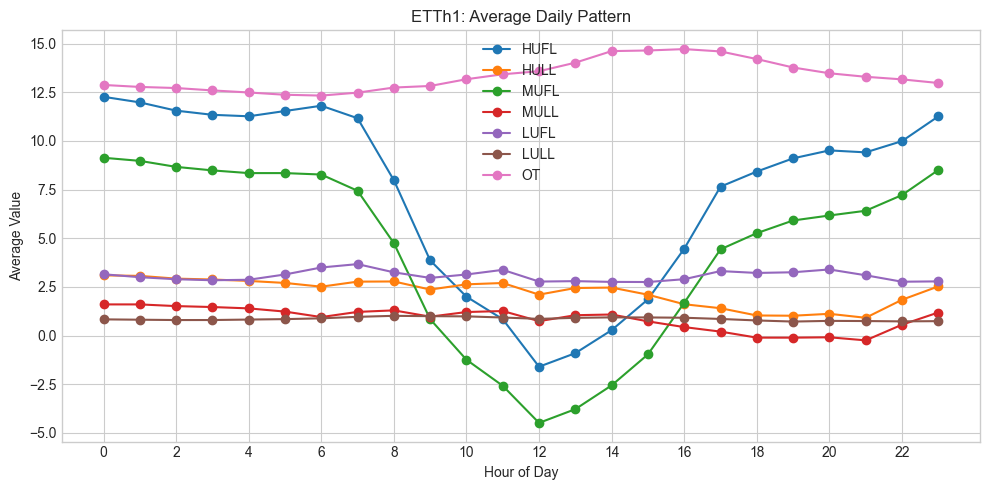

In [12]:
# Daily pattern
ett_df = pd.DataFrame(ett_data, index=ett_time, columns=sensor_names)
ett_df['hour'] = ett_df.index.hour

hourly_ett = ett_df.groupby('hour').mean()

fig, ax = plt.subplots(figsize=(10, 5))
for col in sensor_names:
    ax.plot(hourly_ett.index, hourly_ett[col], marker='o', label=col)

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Value')
ax.set_title('ETTh1: Average Daily Pattern')
ax.legend()
ax.set_xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

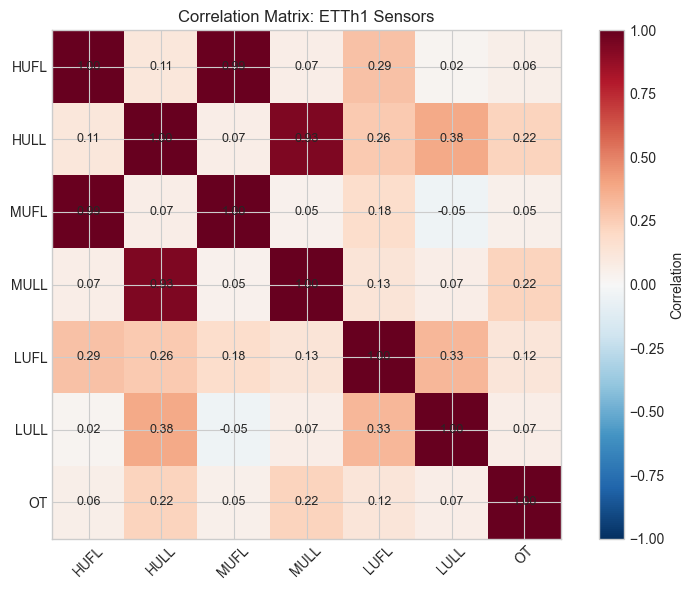

Average pairwise correlation: 0.218


In [13]:
# Correlation matrix
corr_ett = np.corrcoef(ett_data.T)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_ett, cmap='RdBu_r', vmin=-1, vmax=1)

ax.set_xticks(range(len(sensor_names)))
ax.set_yticks(range(len(sensor_names)))
ax.set_xticklabels(sensor_names, rotation=45)
ax.set_yticklabels(sensor_names)

for i in range(len(sensor_names)):
    for j in range(len(sensor_names)):
        ax.text(j, i, f'{corr_ett[i, j]:.2f}', ha='center', va='center', fontsize=9)

ax.set_title('Correlation Matrix: ETTh1 Sensors')
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

print(f"Average pairwise correlation: {corr_ett[np.triu_indices(7, k=1)].mean():.3f}")

---
## Summary: Which Dataset for Joint Imputation?

| Dataset | Nodes | Avg Correlation | Shared Structure | Best For |
|---------|-------|-----------------|------------------|----------|
| **electricity** | 321 | ~0.3-0.5 | Daily/weekly cycles | Full benchmark, scalability test |
| **exchange_rate** | 8 | ~0.5-0.7 | Economic correlation | Quick experiments, demos |
| **ETTh1** | 7 | ~0.7-0.9 | Physical co-location | Highest correlation, clearest benefit |

### Recommendations:
1. **Start with exchange_rate** - small, fast to iterate, clear economic interpretation
2. **Then ETTh1** - strongest correlations, joint method should clearly outperform
3. **Scale to electricity** - real benchmark with 321 series

In [14]:
# Summary comparison
datasets = {
    'electricity': (elec_data, elec_time),
    'exchange_rate': (exch_data, exch_time),
    'ETTh1': (ett_data, ett_time)
}

print("Dataset Comparison")
print("="*70)
print(f"{'Dataset':<15} {'Shape':<20} {'Avg Corr':<12} {'Time Range'}")
print("-"*70)

for name, (data, time) in datasets.items():
    corr = np.corrcoef(data.T)
    n = data.shape[1]
    avg_corr = corr[np.triu_indices(n, k=1)].mean()
    time_range = f"{time[0].strftime('%Y-%m-%d')} to {time[-1].strftime('%Y-%m-%d')}"
    print(f"{name:<15} {str(data.shape):<20} {avg_corr:<12.3f} {time_range}")

Dataset Comparison
Dataset         Shape                Avg Corr     Time Range
----------------------------------------------------------------------
electricity     (26304, 321)         0.463        2016-07-01 to 2019-07-02
exchange_rate   (7588, 8)            0.480        1990-01-01 to 2010-10-10
ETTh1           (17420, 7)           0.218        2016-07-01 to 2018-06-26
